In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from keras.models import load_model
from sklearn.metrics import log_loss
import json
from sklearn.model_selection import train_test_split

In [2]:
def proba_plot(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    plt.plot(x,y)
    
def proba_data(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    return x,y

def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

In [3]:
df = pd.read_feather('big_frame_4.feather')
x_train,x_test,y_train,y_test = train_test_split(df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values,test_size = .25,random_state = 333)

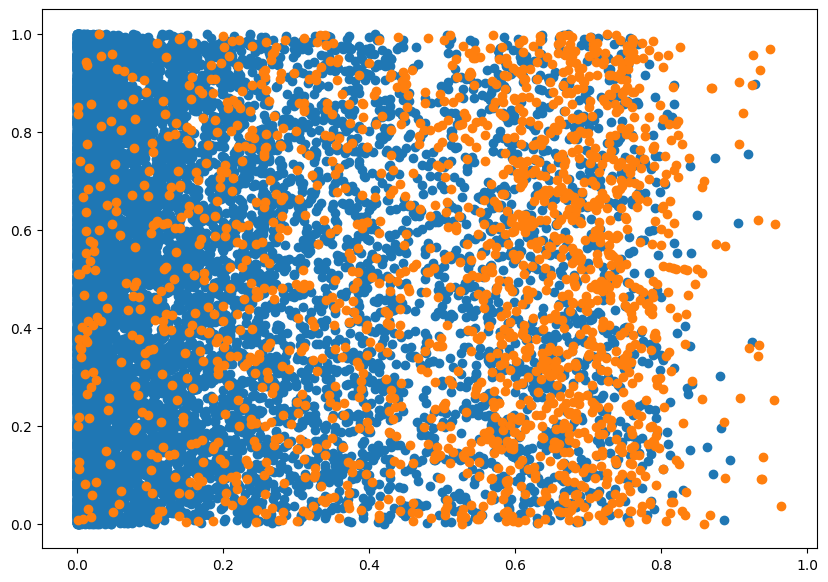

In [4]:
# xgb_model = XGBClassifier(scale_pos_weight = 2,max_depth = 2,eta = .4).fit(x_train, y_train)
xgb_model = XGBClassifier()
xgb_model.load_model('model_load.json')
prediction = xgb_model.predict_proba(x_test)[:,1]
plt.figure(figsize = (10,7))
plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))
plt.show()

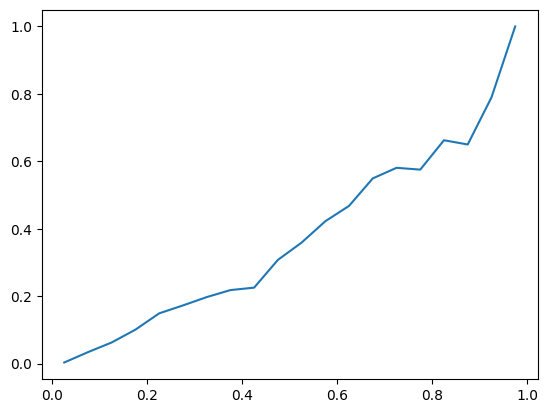

In [5]:
proba_plot(y_test,prediction,0.05)

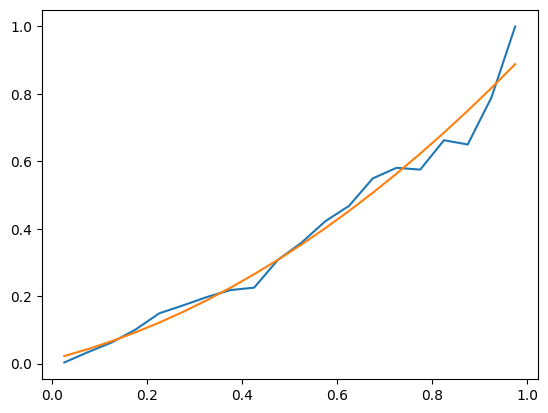

In [6]:
xgb_model.save_model('model_load.json')
probx,proby = proba_data(y_test,prediction,0.05)
popt = curve_fit(square,probx,proby)[0]
curve_values = [square(x,*popt) for x in probx]
with open('coef.json','w') as file:
    json.dump(list(popt),file)
plt.plot(probx,proby)
plt.plot(probx,curve_values)
plt.show()

In [4]:
neural = load_model('model_DeepV2.h5')
xgb_model = XGBClassifier()
xgb_model.load_model('model_load.json')
coef = json.load(open('coef.json','r'))

In [8]:
class Arua:
    def __init__(self,model,popt):
        self.model = model
        self.func = np.vectorize(lambda x: square(x,*popt))
    def predict(self,x):
        if len(x.shape) == 1:
            return float(self.func(self.model.predict_proba(x.reshape(-1,17))[:,1][0]))
        return self.func(self.model.predict_proba(x)[:,1])
    
class Igor:
    def __init__(self,model):
        self.model = model
    def predict(self,x):
        if len(x.shape) == 1:
            return self.model.predict(x.reshape(-1,17))[0][0]
        return self.model.predict(x).ravel()

In [9]:
igor = Igor(neural)
arua = Arua(xgb_model,coef)

## Igor

817/817 [==============================] - 2s 2ms/step
Erro: 0.12324457807148487


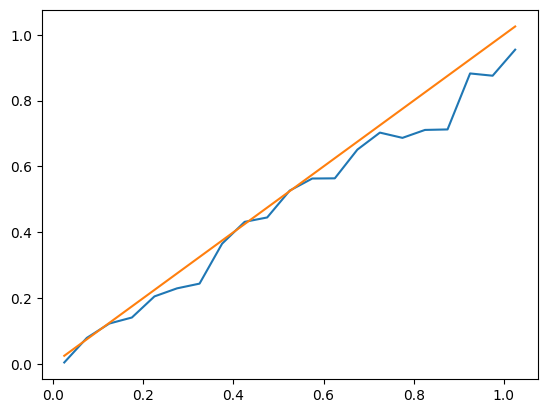

In [10]:
prediction = igor.predict(x_test)
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()

## Aruã

Erro: 0.14329466931492227


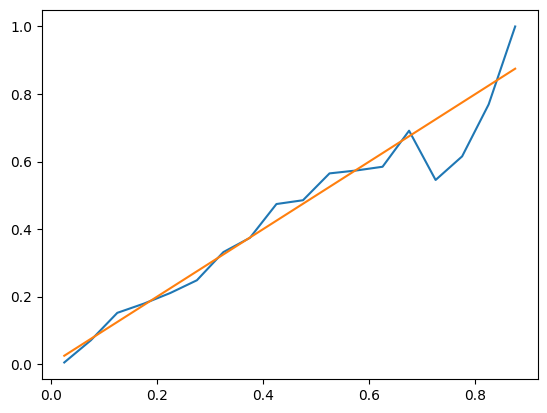

In [11]:
prediction = arua.predict(x_test)
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()

## Assembly simples

In [12]:
arua_pred = arua.predict(x_train)
igor_pred = igor.predict(x_train)
best_model = np.abs(igor_pred - y_train) < np.abs(arua_pred - y_train)

2449/2449 [==============================] - 4s 2ms/step


In [13]:
weight = best_model.sum() / len(best_model)
weight

0.8707392708107349

817/817 [==============================] - 2s 2ms/step
Erro: 0.11441644886836207


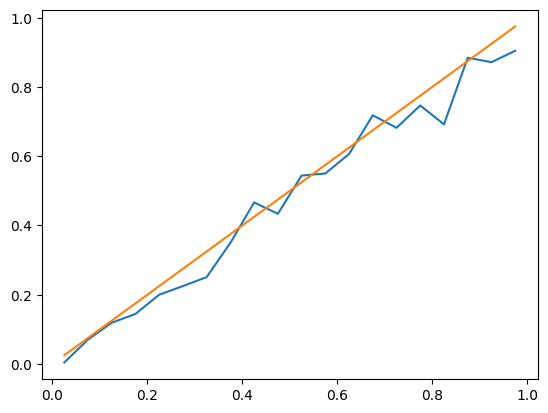

In [14]:
prediction = igor.predict(x_test) * weight + arua.predict(x_test) * (1 - weight)
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()

## Assembly complexo

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
clf = XGBClassifier()
params = {'scale_pos_weight':np.arange(0,5),'eta':np.arange(.1,.6,.1),'max_depth':np.arange(1,10)}
search = GridSearchCV(estimator = clf,param_grid = params)
search.fit(x_train,best_model)
search.best_params_

{'eta': 0.2, 'max_depth': 9, 'scale_pos_weight': 1}

In [17]:
assembler = search.best_estimator_

817/817 [==============================] - 2s 2ms/step
Erro: 0.11591406169499488


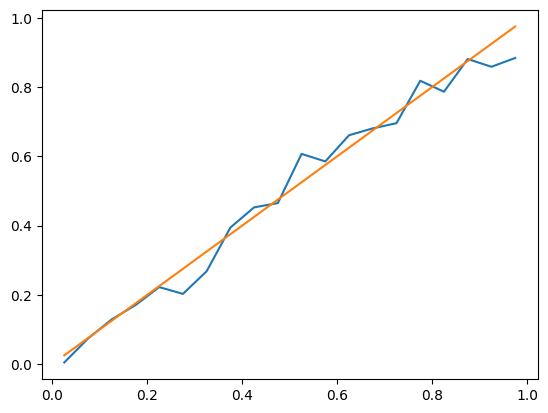

In [19]:
probas_assembler = assembler.predict_proba(x_test)
prediction = igor.predict(x_test) * probas_assembler[:,1] + arua.predict(x_test) * probas_assembler[:,0]
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()